In [1]:
import sys, os
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)


In [2]:
import pandas as pd
from src.load_data import load_data
import src.eda
import importlib
importlib.reload(src.eda)
from src.eda import summarize, missing_check, get_variable_types, plot_correlations, plot_distributions, plot_boxplots, skew_check, calculate_vif, drop_outliers_iqr, one_hot_encode
import numpy as np

In [3]:
# load data
df = load_data("data/airbnb_df.csv")
print(summarize(df))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3982 entries, 0 to 3981
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   listing_id           3982 non-null   int64  
 1   property_type        3982 non-null   object 
 2   number_of_bedrooms   3982 non-null   int64  
 3   guest_capacity       3982 non-null   int64  
 4   location_score       3982 non-null   float64
 5   review_score         3982 non-null   float64
 6   amenities_count      3982 non-null   int64  
 7   host_response_time   3982 non-null   object 
 8   season               3982 non-null   object 
 9   minimum_stay_nights  3982 non-null   int64  
 10  years_as_host        3982 non-null   float64
 11  cleaning_fee         3982 non-null   float64
 12  cancellation_policy  3982 non-null   object 
 13  nightly_rate         3982 non-null   float64
dtypes: float64(5), int64(5), object(4)
memory usage: 435.7+ KB
None
          listing_id  nu

In [4]:
# See the first 5 rows
df.head()

,listing_id,property_type,number_of_bedrooms,guest_capacity,location_score,review_score,amenities_count,host_response_time,season,minimum_stay_nights,years_as_host,cleaning_fee,cancellation_policy,nightly_rate
0,100822,Standard Apartment,2,4,75.17,4.87,8,within an hour,peak,2,1.6,21.43,flexible,187.29
1,100908,Standard Apartment,2,3,67.07,4.06,6,>24 hours,off-peak,2,4.1,38.30,flexible,255.64
2,101850,Standard Apartment,1,2,76.57,4.16,10,same day,off-peak,1,2.3,50.34,flexible,62.82
3,102385,Standard Apartment,2,2,88.14,3.74,11,same day,shoulder,2,1.6,35.37,strict,203.80
4,103827,Luxury Home,4,4,58.63,3.37,15,same day,peak,4,0.9,94.90,strict,1000.00


In [5]:
# check missing value
missing_check(df)

listing_id             0
property_type          0
number_of_bedrooms     0
guest_capacity         0
location_score         0
review_score           0
amenities_count        0
host_response_time     0
season                 0
minimum_stay_nights    0
years_as_host          0
cleaning_fee           0
cancellation_policy    0
nightly_rate           0
dtype: int64

In [6]:
# classify variable types
num_cols, cat_cols = get_variable_types(df, 0) 
num_cols.remove("listing_id")
print(f'Numerical columns: {num_cols}')
print(f'Categorical columns: {cat_cols}')
target = df["nightly_rate"]
id = df["listing_id"]

Numerical columns: ['number_of_bedrooms', 'guest_capacity', 'location_score', 'review_score', 'amenities_count', 'minimum_stay_nights', 'years_as_host', 'cleaning_fee', 'nightly_rate']
Categorical columns: ['property_type', 'host_response_time', 'season', 'cancellation_policy']


### Numerical Columns Analysis

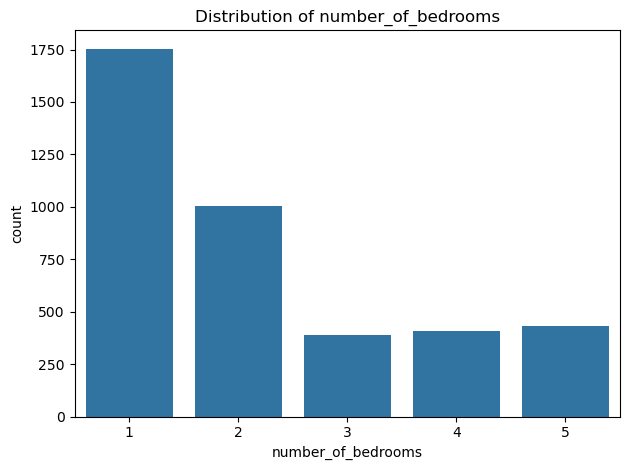

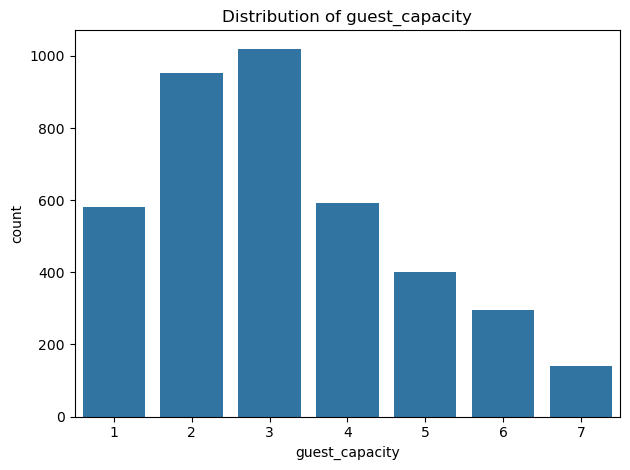

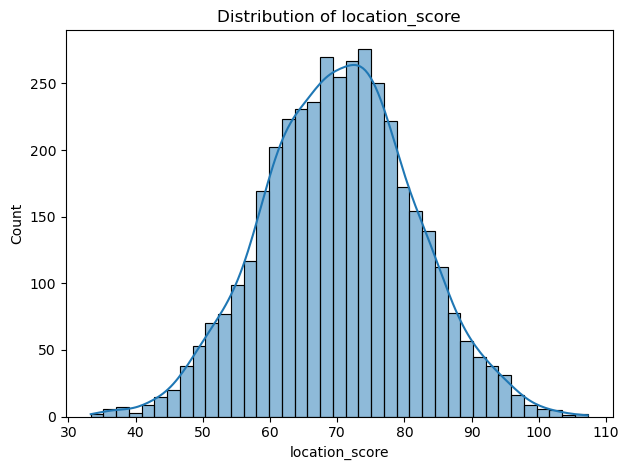

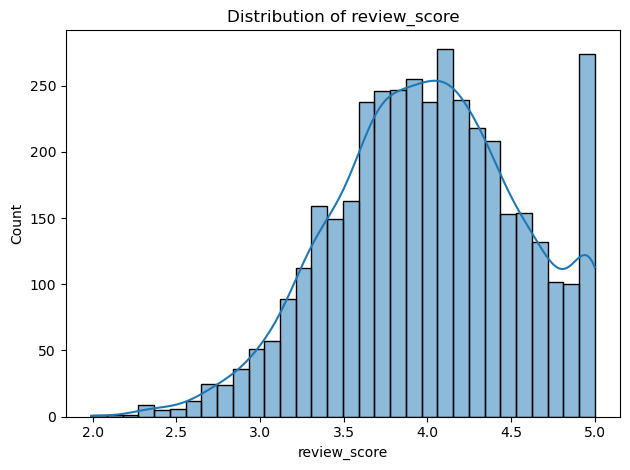

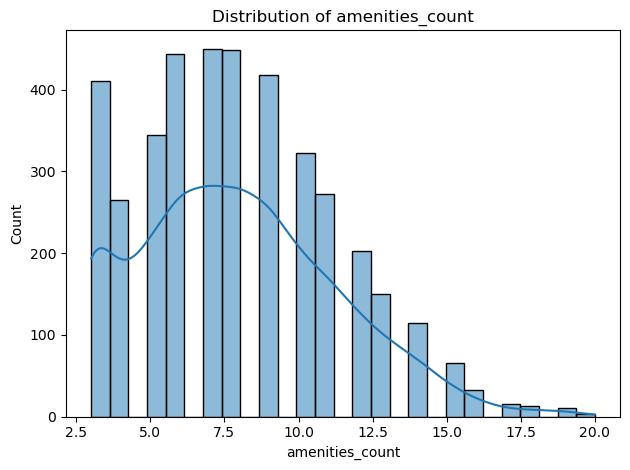

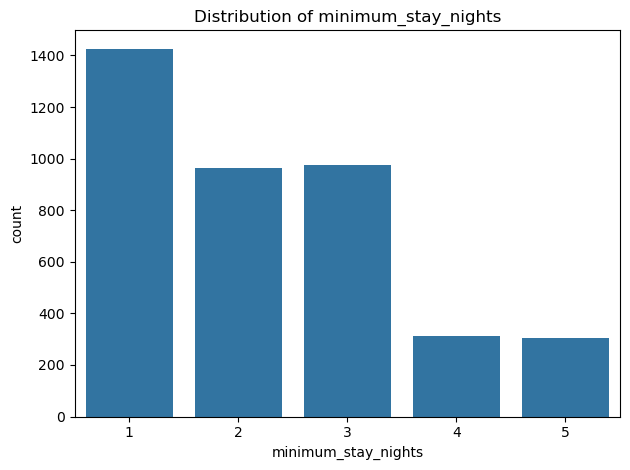

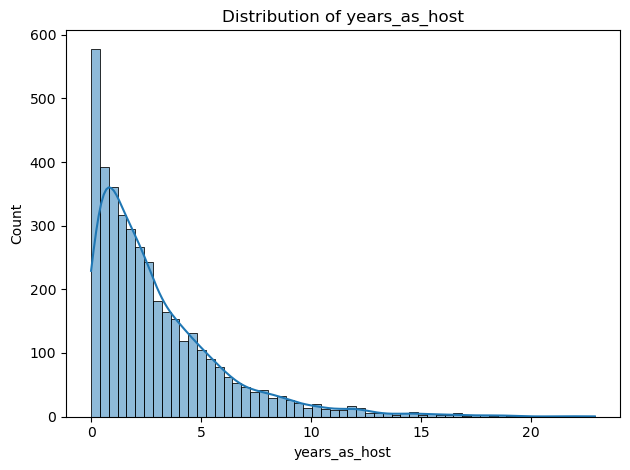

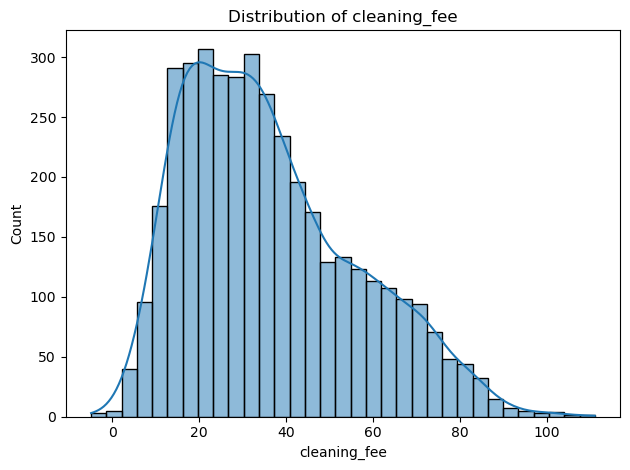

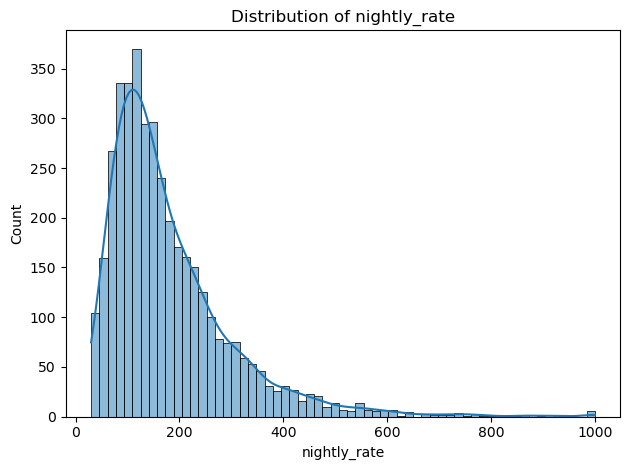

In [7]:
plot_distributions(df, num_cols)

In [8]:
# Check skewness
skew_check(df, num_cols)

number_of_bedrooms     0.903153
guest_capacity         0.581191
location_score        -0.020977
review_score          -0.165083
amenities_count        0.504965
minimum_stay_nights    0.688846
years_as_host          1.943478
cleaning_fee           0.680534
nightly_rate           2.116051
dtype: float64


**High skewness variable: (abs()>0.6)**
- number_of_bedrooms : mostly 1 or 2 bedrooms, could be ordinally encoded into 1, 2, 3+
- minimum_stay_nights : could be ordially encoded into 1, 2, 3, 4+
- years_as_host : Log transform
- cleaning_fee : Log transform



In [9]:
df_processed = df.copy()
# number_of_bedrooms

def bin_bedrooms(x):
    if x == 1:
        return 0
    elif x == 2:
        return 1
    else:
        return 2
    
df_processed["bedroom_group"] = df_processed["number_of_bedrooms"].apply(bin_bedrooms)

# minimum_stay_nights

def bin_min_stay(x):
    if x == 1:
        return 0
    elif x == 2:
        return 1
    elif x == 3:
        return 2
    else:
        return 3
    
df_processed["min_stay_group"] = df_processed["minimum_stay_nights"].apply(bin_min_stay)

# years_as_host, cleaning_fee

df_processed["years_as_host_log"] = np.log1p(df_processed["years_as_host"])
df_processed["cleaning_fee_log"] = np.log1p(df_processed["cleaning_fee"])
df_processed["nightly_rate_log"] = np.log1p(df_processed["nightly_rate"])

original_high_skew_cols = ["number_of_bedrooms", "minimum_stay_nights", "years_as_host", "cleaning_fee", "nightly_rate"]
processed_high_skew_cols = ["bedroom_group", "min_stay_group", "years_as_host_log", "cleaning_fee_log", "nightly_rate_log"]


/opt/homebrew/Caskroom/miniconda/base/envs/ise535_project/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [10]:
num_cols_processed = list(set(num_cols) - {"number_of_bedrooms", "minimum_stay_nights", "years_as_host", "cleaning_fee", "nightly_rate"}) + ["bedroom_group", "min_stay_group", "years_as_host_log", "cleaning_fee_log", "nightly_rate_log"]
num_cols_processed

['location_score',
 'guest_capacity',
 'review_score',
 'amenities_count',
 'bedroom_group',
 'min_stay_group',
 'years_as_host_log',
 'cleaning_fee_log',
 'nightly_rate_log']

In [11]:
df_processed.columns

Index(['listing_id', 'property_type', 'number_of_bedrooms', 'guest_capacity',
       'location_score', 'review_score', 'amenities_count',
       'host_response_time', 'season', 'minimum_stay_nights', 'years_as_host',
       'cleaning_fee', 'cancellation_policy', 'nightly_rate', 'bedroom_group',
       'min_stay_group', 'years_as_host_log', 'cleaning_fee_log',
       'nightly_rate_log'],
      dtype='object')

In [12]:
skew_check(df_processed, num_cols_processed)

location_score      -0.020977
guest_capacity       0.581191
review_score        -0.165083
amenities_count      0.504965
bedroom_group        0.256906
min_stay_group       0.326179
years_as_host_log    0.256794
cleaning_fee_log    -0.649864
nightly_rate_log     0.073584
dtype: float64

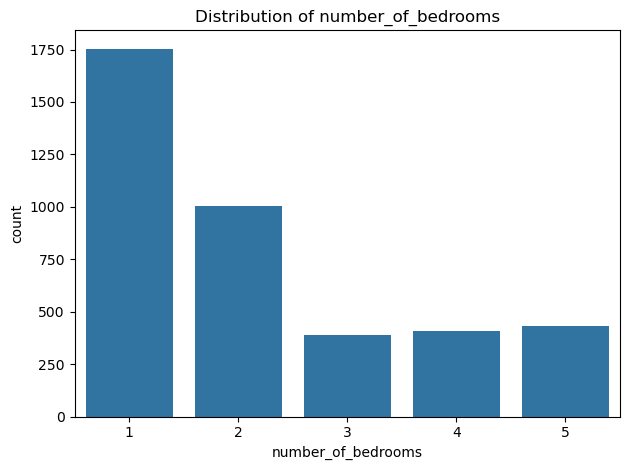

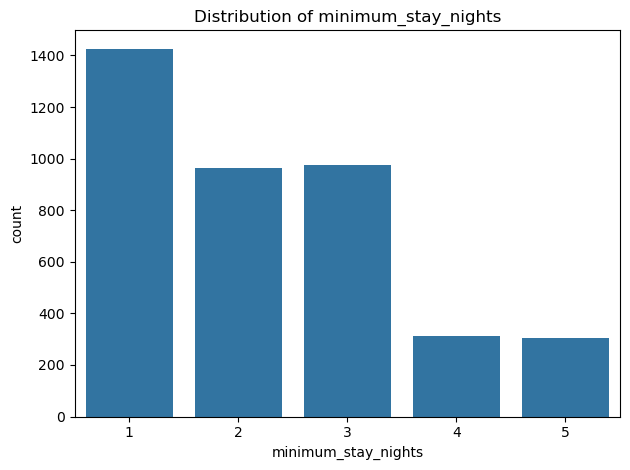

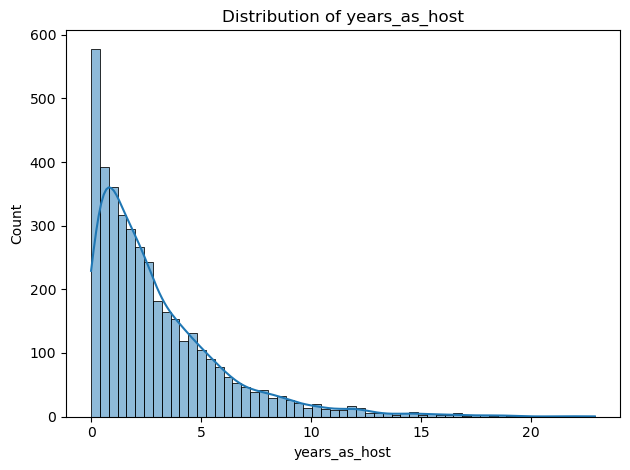

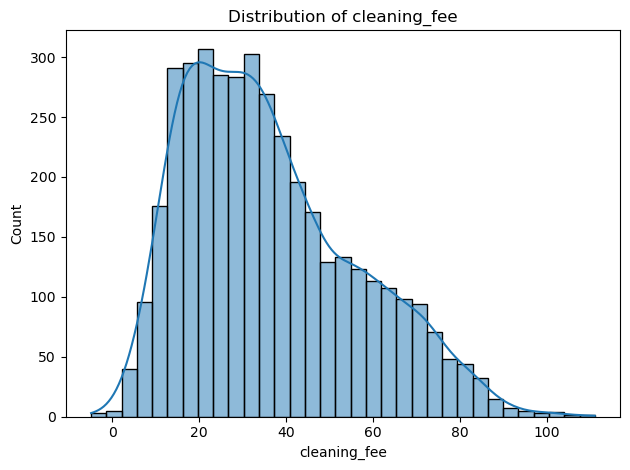

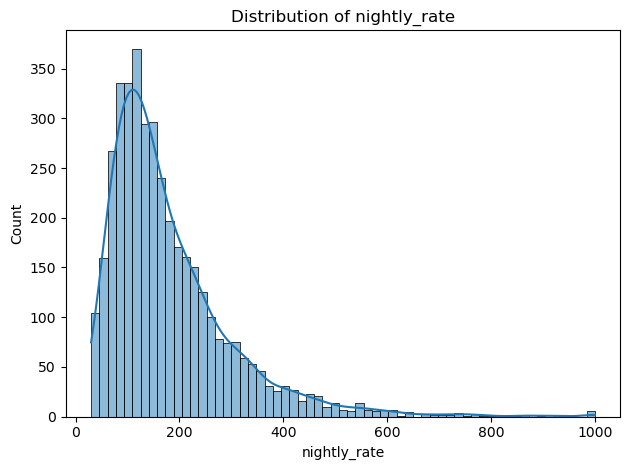

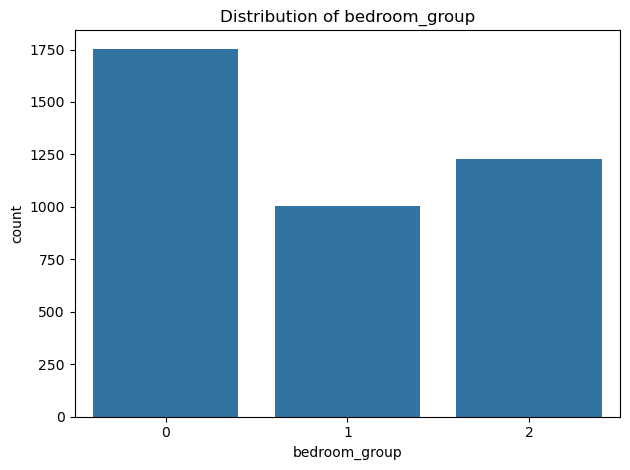

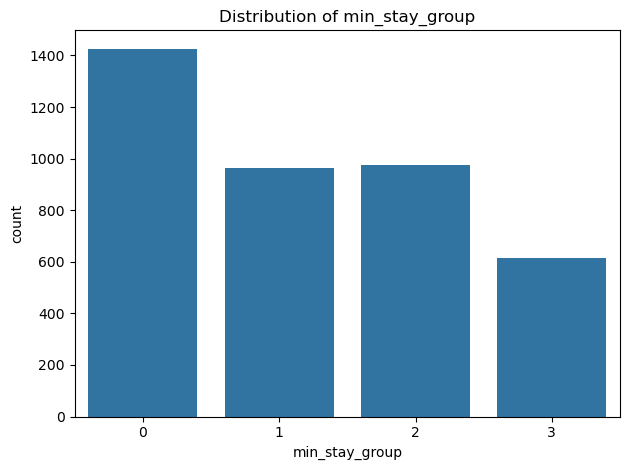

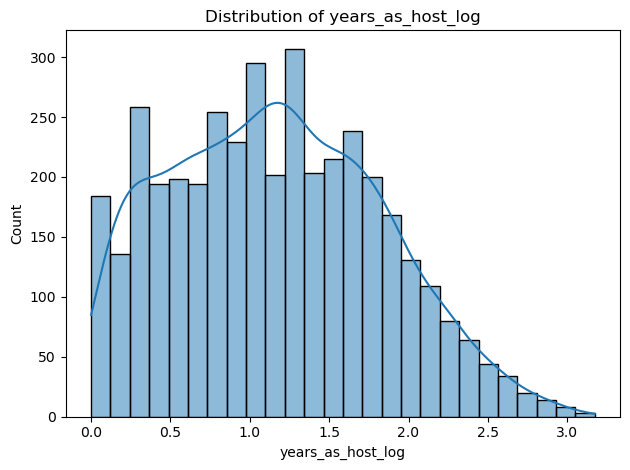

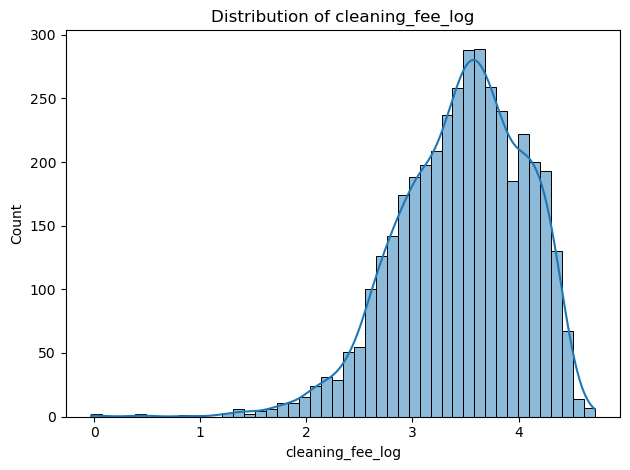

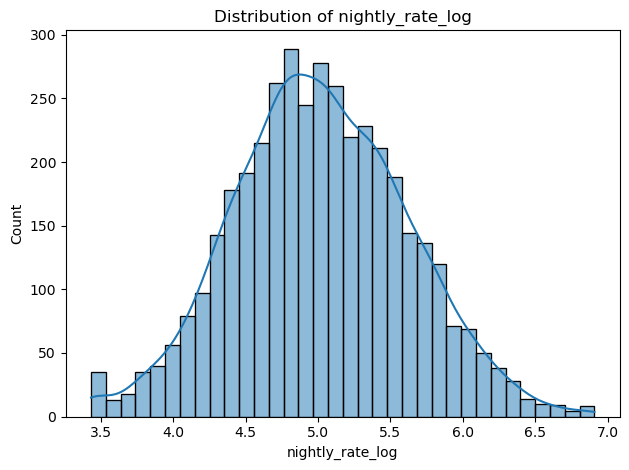

In [13]:
plot_distributions(df[original_high_skew_cols], original_high_skew_cols)
plot_distributions(df_processed[processed_high_skew_cols], processed_high_skew_cols)


In [14]:
# Outliers

df_outlier_processed = drop_outliers_iqr(df_processed, num_cols_processed)

Dropped 128 rows due to outliers in ['location_score', 'guest_capacity', 'review_score', 'amenities_count', 'bedroom_group', 'min_stay_group', 'years_as_host_log', 'cleaning_fee_log', 'nightly_rate_log'].


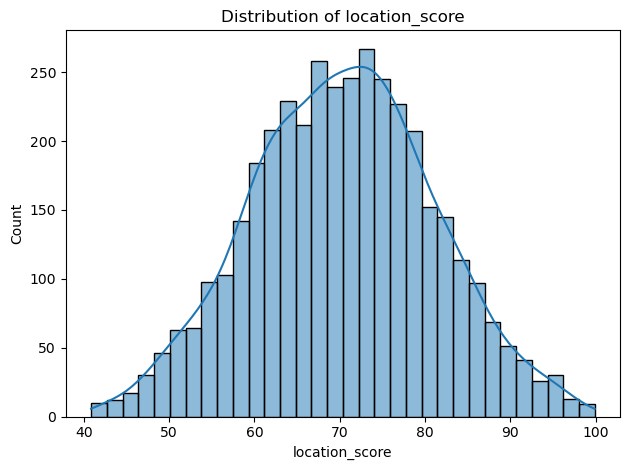

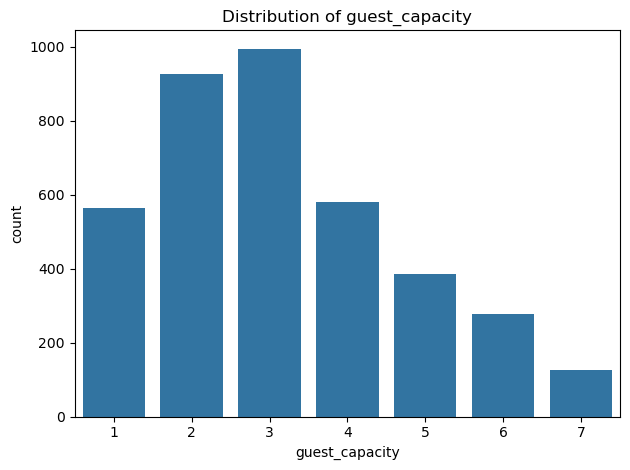

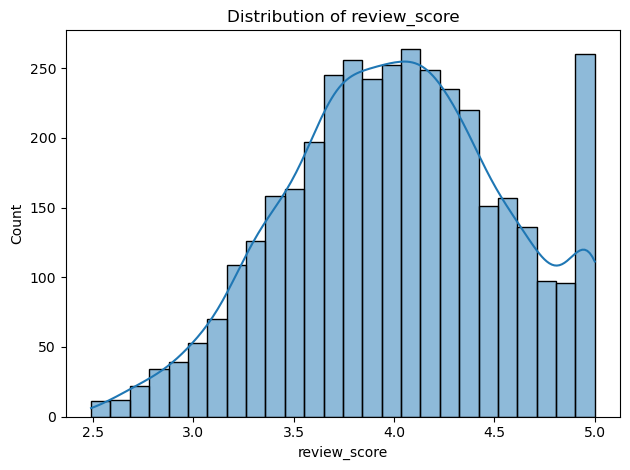

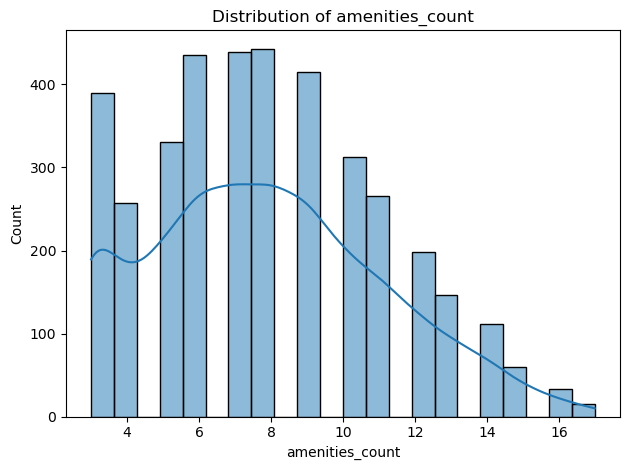

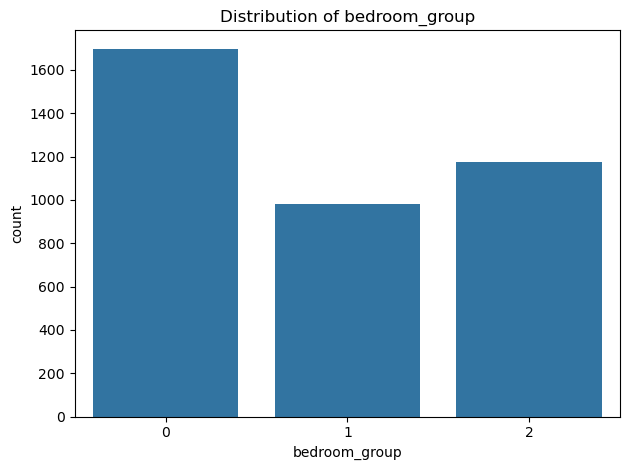

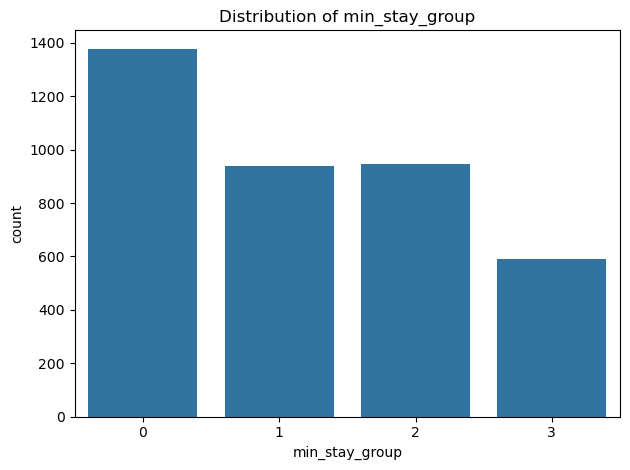

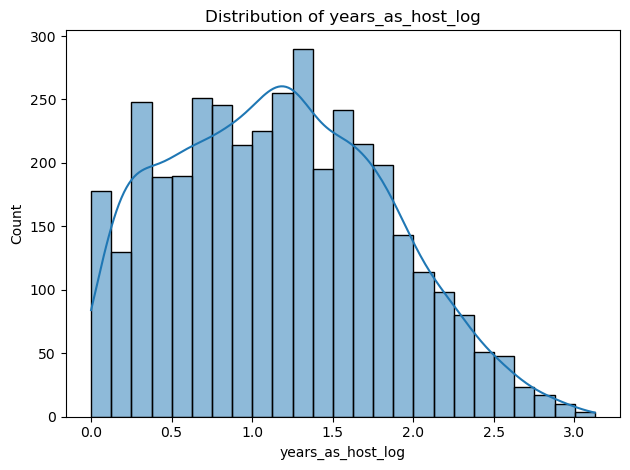

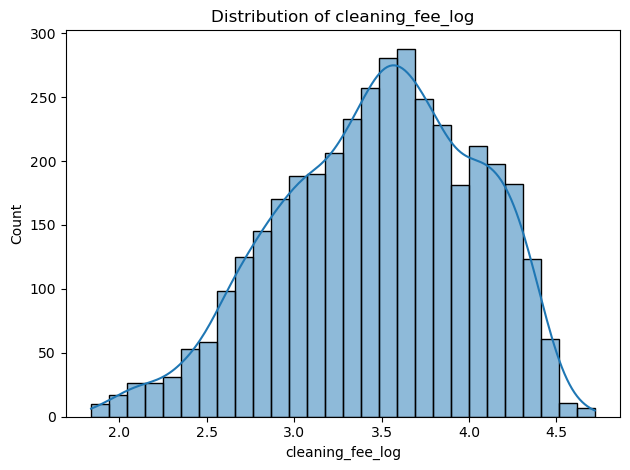

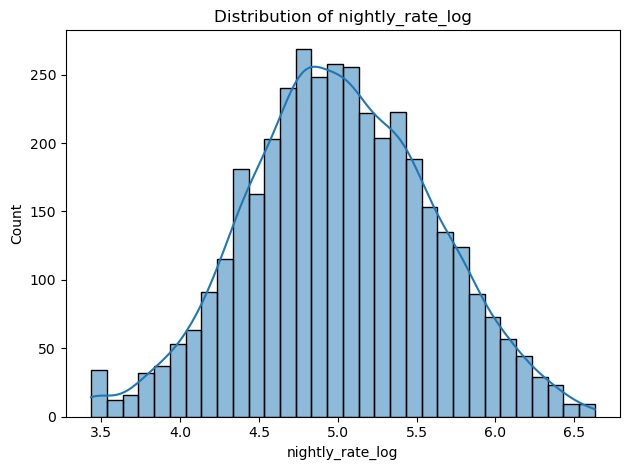

In [15]:
plot_distributions(df_outlier_processed, num_cols_processed)

In [16]:
skew_check(df_outlier_processed, num_cols_processed)

location_score       0.007064
guest_capacity       0.582659
review_score        -0.089882
amenities_count      0.377948
bedroom_group        0.263644
min_stay_group       0.327842
years_as_host_log    0.250313
cleaning_fee_log    -0.332236
nightly_rate_log    -0.005780
dtype: float64

In [17]:
df_outlier_processed.columns

Index(['listing_id', 'property_type', 'number_of_bedrooms', 'guest_capacity',
       'location_score', 'review_score', 'amenities_count',
       'host_response_time', 'season', 'minimum_stay_nights', 'years_as_host',
       'cleaning_fee', 'cancellation_policy', 'nightly_rate', 'bedroom_group',
       'min_stay_group', 'years_as_host_log', 'cleaning_fee_log',
       'nightly_rate_log'],
      dtype='object')

/var/folders/g7/ywy168rn101ghvrp2dr_6xh40000gn/T/ipykernel_94628/4190399778.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_review_5', y=var, data=df_outlier_processed, palette="Set2")
/var/folders/g7/ywy168rn101ghvrp2dr_6xh40000gn/T/ipykernel_94628/4190399778.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_review_5', y=var, data=df_outlier_processed, palette="Set2")
/var/folders/g7/ywy168rn101ghvrp2dr_6xh40000gn/T/ipykernel_94628/4190399778.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_review_5', y=var, da

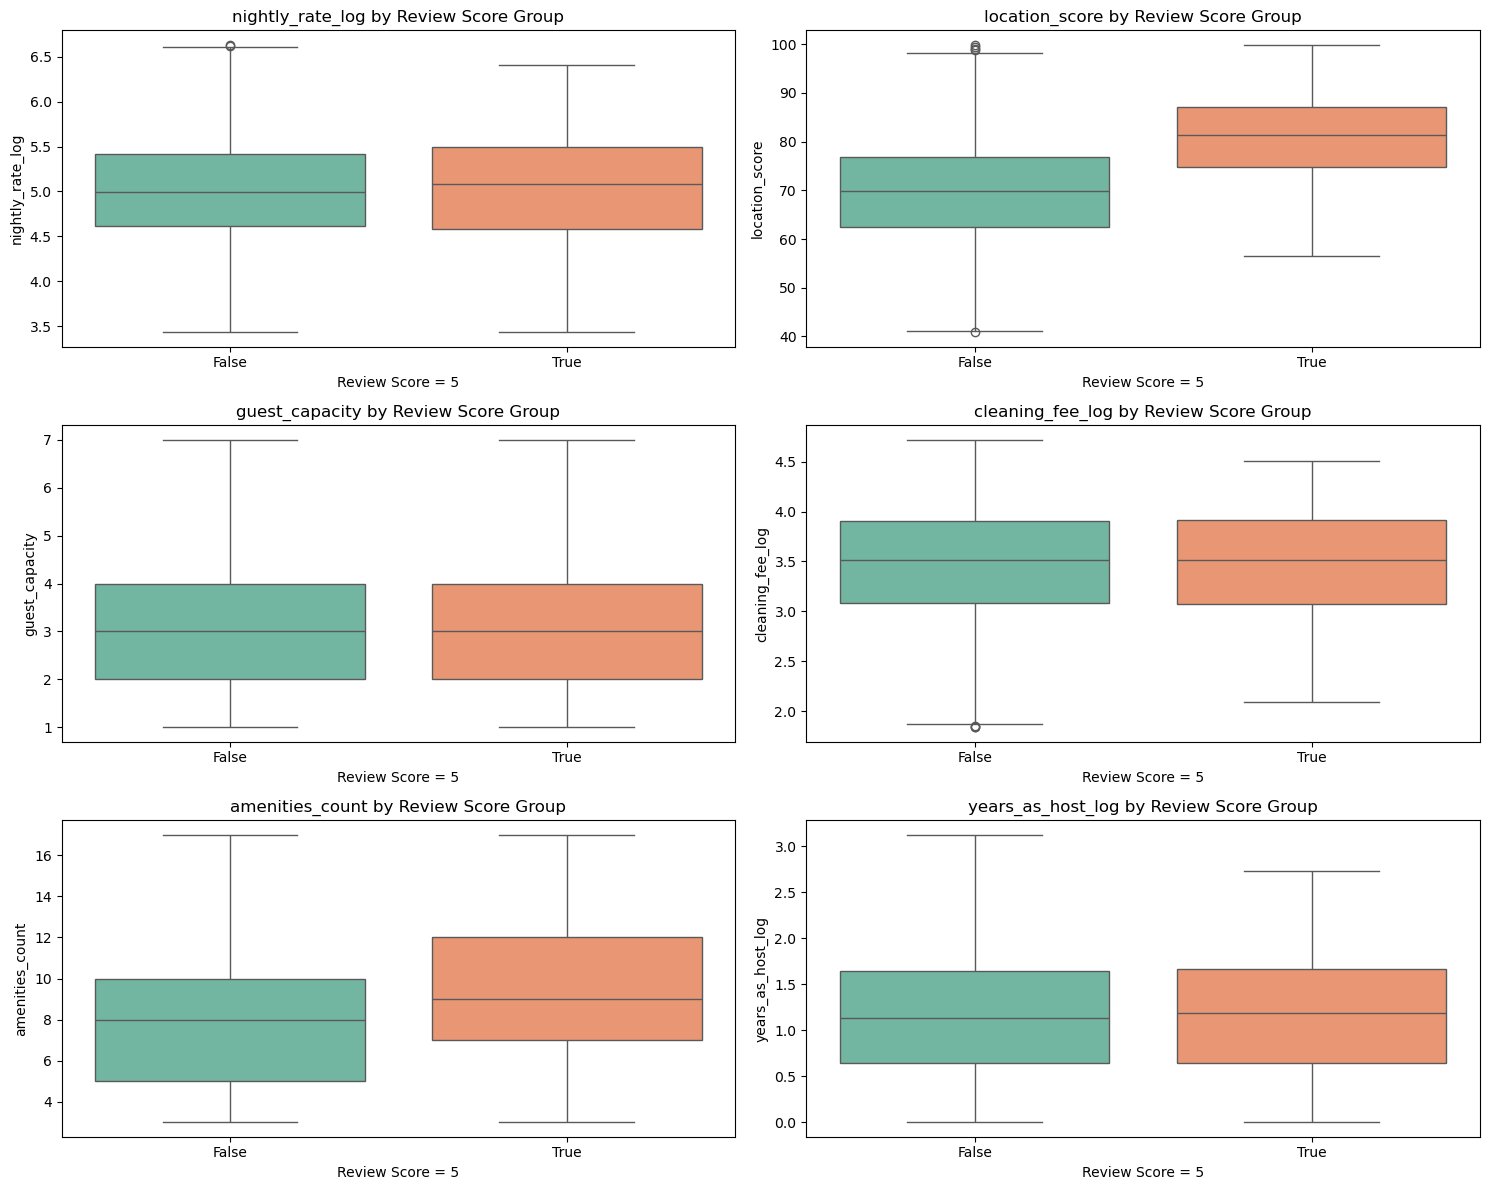

In [18]:
# Check the 5.0 score on review_score
import seaborn as sns
import matplotlib.pyplot as plt

df_outlier_processed[df_outlier_processed["review_score"] == 5.0].describe().T
df_outlier_processed['is_review_5'] = df_outlier_processed['review_score'] == 5
num_vars = ['nightly_rate_log', 'location_score', 'guest_capacity', 
            'cleaning_fee_log', 'amenities_count', 'years_as_host_log']

# 畫出每個變數的 boxplot
plt.figure(figsize=(15, 12))
for i, var in enumerate(num_vars, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(x='is_review_5', y=var, data=df_outlier_processed, palette="Set2")
    plt.title(f'{var} by Review Score Group')
    plt.xlabel('Review Score = 5')
    plt.ylabel(var)

plt.tight_layout()
plt.show()

In [19]:
group_5 = df_outlier_processed[df_outlier_processed['review_score'] == 5]
group_non5 = df_outlier_processed[df_outlier_processed['review_score'] < 5]

from scipy.stats import ttest_ind

for var in num_vars:
    t_stat, p_value = ttest_ind(group_5[var], group_non5[var], equal_var=False)
    print(f"{var:20}: p-value = {p_value:.4f}")

nightly_rate_log    : p-value = 0.3718
location_score      : p-value = 0.0000
guest_capacity      : p-value = 0.8987
cleaning_fee_log    : p-value = 0.8359
amenities_count     : p-value = 0.0000
years_as_host_log   : p-value = 0.6214


In [20]:
df_outlier_processed = df_outlier_processed.drop(columns=['is_review_5'])

In [21]:
df_outlier_processed.columns

Index(['listing_id', 'property_type', 'number_of_bedrooms', 'guest_capacity',
       'location_score', 'review_score', 'amenities_count',
       'host_response_time', 'season', 'minimum_stay_nights', 'years_as_host',
       'cleaning_fee', 'cancellation_policy', 'nightly_rate', 'bedroom_group',
       'min_stay_group', 'years_as_host_log', 'cleaning_fee_log',
       'nightly_rate_log'],
      dtype='object')

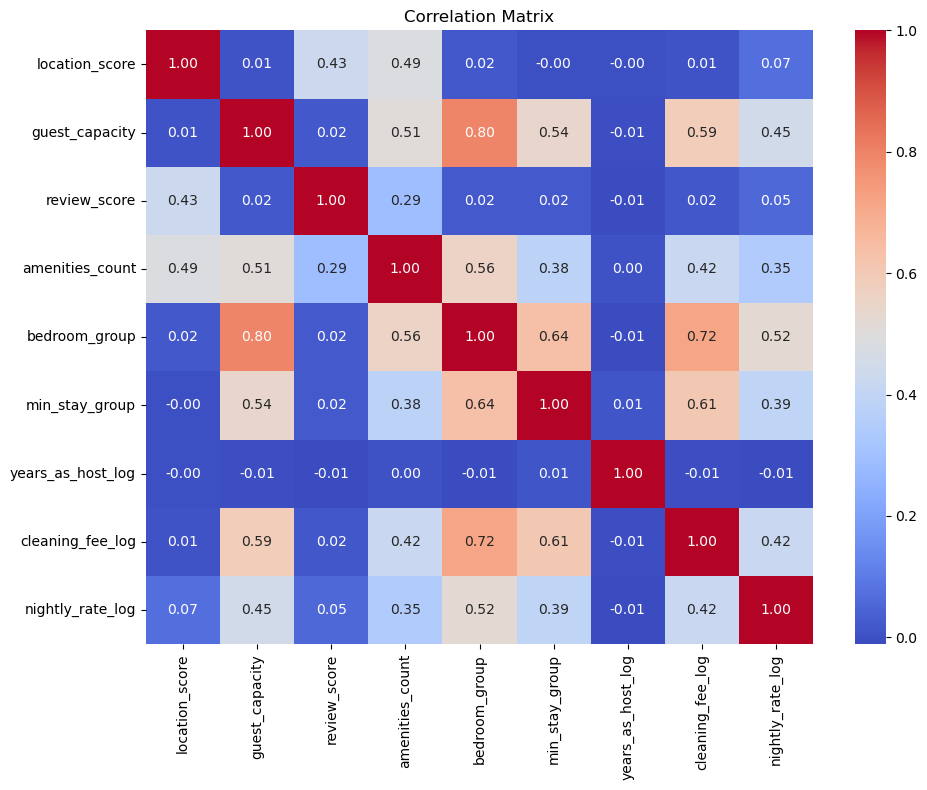

In [22]:
# Correlation Matrix

plot_correlations(df_outlier_processed[num_cols_processed])

#### 1. Correlation between Target(nightly_rate) and variables
     
**High correlation**

- bedroom_encoded(0.51)
- guest_capacity(0.45)
- cleaning_fee_log(0.41)
- min_stay_encoded(0.39)
- amentities_count(0.35)

**Low correlation**

- location_score(0.06)
- review_score (0.06)
- years_at_host_log(-0.01)

-> For LR model : Keep high correlation features, remove low correlation features

#### 2. Correlation between variables

For correlation > 0.6:
- bedroom_encoded <-> guest_capacity
- bedroom_encoded <-> cleaning_fee_log
- bedroom_encoded <-> min_stay_encoded

-> Drop bedroom_encoded variable



In [30]:
low_corr_col = ['location_score', 'review_score', 'years_as_host_log']
num_cols_LR = list(set(num_cols_processed) - set(low_corr_col))
df_LR = df_outlier_processed[num_cols_LR + cat_cols].copy()

In [31]:
df_LR.columns

Index(['cleaning_fee_log', 'bedroom_group', 'min_stay_group', 'guest_capacity',
       'nightly_rate_log', 'amenities_count', 'property_type',
       'host_response_time', 'season', 'cancellation_policy'],
      dtype='object')

In [32]:
print(num_cols_LR)

['cleaning_fee_log', 'bedroom_group', 'min_stay_group', 'guest_capacity', 'nightly_rate_log', 'amenities_count']


In [33]:
print(df_LR.columns)
print(df_outlier_processed.columns)

Index(['cleaning_fee_log', 'bedroom_group', 'min_stay_group', 'guest_capacity',
       'nightly_rate_log', 'amenities_count', 'property_type',
       'host_response_time', 'season', 'cancellation_policy'],
      dtype='object')
Index(['listing_id', 'property_type', 'number_of_bedrooms', 'guest_capacity',
       'location_score', 'review_score', 'amenities_count',
       'host_response_time', 'season', 'minimum_stay_nights', 'years_as_host',
       'cleaning_fee', 'cancellation_policy', 'nightly_rate', 'bedroom_group',
       'min_stay_group', 'years_as_host_log', 'cleaning_fee_log',
       'nightly_rate_log'],
      dtype='object')


### Categorical Columns

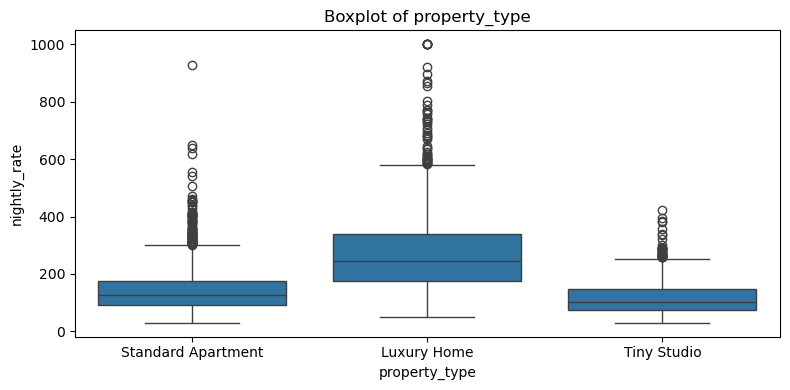

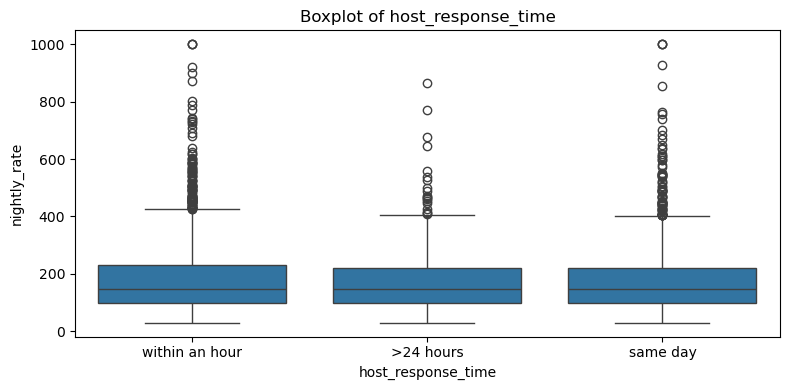

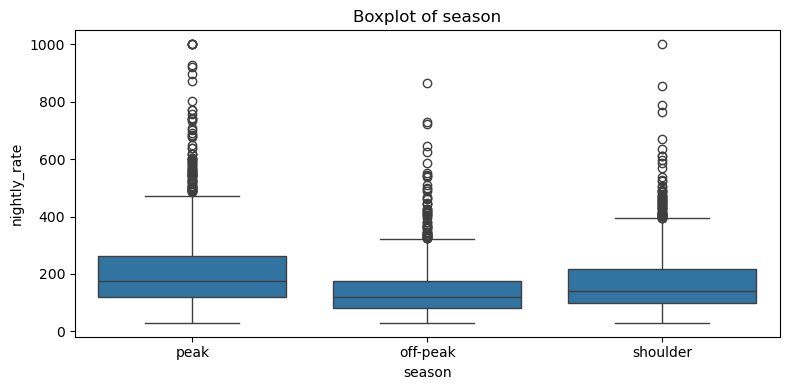

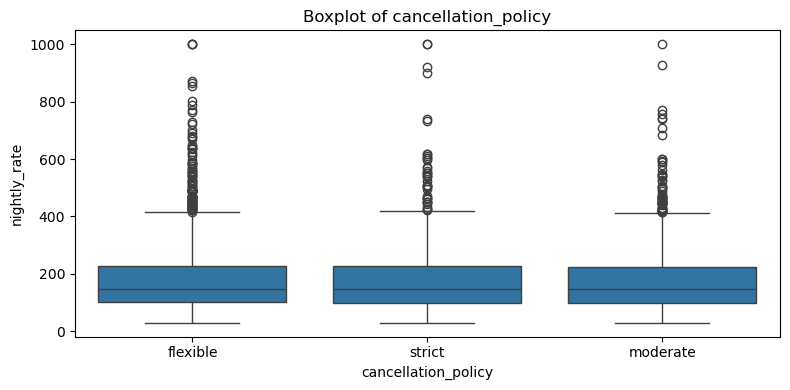

In [34]:
plot_boxplots(df, cat_cols, target)

In [35]:
df_LR_final = one_hot_encode(df_LR, cat_cols, dtype=int)
df_LR_final.head()

,cleaning_fee_log,bedroom_group,min_stay_group,guest_capacity,nightly_rate_log,amenities_count,property_type_Standard Apartment,property_type_Tiny Studio,host_response_time_same day,host_response_time_within an hour,season_peak,season_shoulder,cancellation_policy_moderate,cancellation_policy_strict
0,3.110399,1,1,4,5.237983,8,1,0,0,1,1,0,0,0
1,3.671225,1,1,3,5.547674,6,1,0,0,0,0,0,0,0
2,3.938470,0,0,2,4.156067,10,1,0,1,0,0,0,0,0
3,3.593744,1,1,2,5.322034,11,1,0,1,0,0,1,0,1
5,2.895912,0,0,3,4.976803,7,0,1,0,0,0,1,0,1


In [40]:
df_clean_final = one_hot_encode(df_outlier_processed.drop(columns=["listing_id"]), cat_cols, dtype=int)
df_clean_final.head()

,number_of_bedrooms,guest_capacity,location_score,review_score,amenities_count,minimum_stay_nights,years_as_host,cleaning_fee,nightly_rate,bedroom_group,...,cleaning_fee_log,nightly_rate_log,property_type_Standard Apartment,property_type_Tiny Studio,host_response_time_same day,host_response_time_within an hour,season_peak,season_shoulder,cancellation_policy_moderate,cancellation_policy_strict
0,2,4,75.17,4.87,8,2,1.6,21.43,187.29,1,...,3.110399,5.237983,1,0,0,1,1,0,0,0
1,2,3,67.07,4.06,6,2,4.1,38.30,255.64,1,...,3.671225,5.547674,1,0,0,0,0,0,0,0
2,1,2,76.57,4.16,10,1,2.3,50.34,62.82,0,...,3.938470,4.156067,1,0,1,0,0,0,0,0
3,2,2,88.14,3.74,11,2,1.6,35.37,203.80,1,...,3.593744,5.322034,1,0,1,0,0,1,0,1
5,1,3,72.66,4.11,7,1,0.4,17.10,144.01,0,...,2.895912,4.976803,0,1,0,0,0,1,0,1


In [45]:
df_clean_withid = df_outlier_processed.copy()
df_clean_withid.head()

,listing_id,property_type,number_of_bedrooms,guest_capacity,location_score,review_score,amenities_count,host_response_time,season,minimum_stay_nights,years_as_host,cleaning_fee,cancellation_policy,nightly_rate,bedroom_group,min_stay_group,years_as_host_log,cleaning_fee_log,nightly_rate_log
0,100822,Standard Apartment,2,4,75.17,4.87,8,within an hour,peak,2,1.6,21.43,flexible,187.29,1,1,0.955511,3.110399,5.237983
1,100908,Standard Apartment,2,3,67.07,4.06,6,>24 hours,off-peak,2,4.1,38.30,flexible,255.64,1,1,1.629241,3.671225,5.547674
2,101850,Standard Apartment,1,2,76.57,4.16,10,same day,off-peak,1,2.3,50.34,flexible,62.82,0,0,1.193922,3.938470,4.156067
3,102385,Standard Apartment,2,2,88.14,3.74,11,same day,shoulder,2,1.6,35.37,strict,203.80,1,1,0.955511,3.593744,5.322034
5,100701,Tiny Studio,1,3,72.66,4.11,7,>24 hours,shoulder,1,0.4,17.10,strict,144.01,0,0,0.336472,2.895912,4.976803


In [43]:
df_stats = df_outlier_processed.drop(columns=["listing_id"]).copy()
df_stats.head()

,property_type,number_of_bedrooms,guest_capacity,location_score,review_score,amenities_count,host_response_time,season,minimum_stay_nights,years_as_host,cleaning_fee,cancellation_policy,nightly_rate,bedroom_group,min_stay_group,years_as_host_log,cleaning_fee_log,nightly_rate_log
0,Standard Apartment,2,4,75.17,4.87,8,within an hour,peak,2,1.6,21.43,flexible,187.29,1,1,0.955511,3.110399,5.237983
1,Standard Apartment,2,3,67.07,4.06,6,>24 hours,off-peak,2,4.1,38.30,flexible,255.64,1,1,1.629241,3.671225,5.547674
2,Standard Apartment,1,2,76.57,4.16,10,same day,off-peak,1,2.3,50.34,flexible,62.82,0,0,1.193922,3.938470,4.156067
3,Standard Apartment,2,2,88.14,3.74,11,same day,shoulder,2,1.6,35.37,strict,203.80,1,1,0.955511,3.593744,5.322034
5,Tiny Studio,1,3,72.66,4.11,7,>24 hours,shoulder,1,0.4,17.10,strict,144.01,0,0,0.336472,2.895912,4.976803


In [46]:
# Save data after EDA Done

df_LR_final.to_csv("../data/df_LR.csv", index=False)
df_clean_final.to_csv("../data/df_tree.csv", index=False)
df_stats.to_csv("../data/df_stats.csv", index=False)
df_clean_withid.to_csv("../data/df_clean_id.csv", index=False)